In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import norm

In [2]:
df = pd.read_csv('Loan_Data.csv')
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [6]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [10]:
def create_fico_buckets(data, num_buckets):
    """
    Creates custom FICO score buckets based on a Decision Tree with a specified number of buckets.
    """
    X = data[['fico_score']]  # Input: FICO scores
    y = data['default']       # Target: Default indicator

    # Train a Decision Tree classifier to find split points
    tree_model = DecisionTreeClassifier(max_leaf_nodes=num_buckets, random_state=42)
    tree_model.fit(X, y)
    
    # Extract the split points (thresholds)
    thresholds = sorted(set(tree_model.tree_.threshold[tree_model.tree_.threshold > 0]))
    print(f"Learned FICO score bin thresholds for {num_buckets} buckets:", thresholds)
    
    # Define the bins using the thresholds
    bins = [300] + thresholds + [850]  # Include lower (300) and upper (850) bounds
    labels = range(1, len(bins))  # Assign ratings: 1 = Best, higher numbers = Worse
    
    # Create FICO score bins
    data['bucket'] = pd.cut(data['fico_score'], bins=bins, labels=labels, right=False)
    
    # Calculate default rate for each bucket
    bin_summary = data.groupby('bucket')['default'].agg(['count', 'sum', 'mean']).reset_index()
    bin_summary.rename(columns={'sum': 'num_defaults', 'mean': 'default_rate'}, inplace=True)
    
    return data, bin_summary, bins

In [11]:
# Specify the number of buckets
num_buckets = 4  # You can change this value as desired

# Create buckets and calculate summary
df, bin_summary, bins = create_fico_buckets(df, num_buckets)

Learned FICO score bin thresholds for 4 buckets: [520.5, 580.5, 640.5]


C:\Users\shrey\AppData\Local\Temp\ipykernel_12580\3960965428.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = data.groupby('bucket')['default'].agg(['count', 'sum', 'mean']).reset_index()


In [12]:
print("\nData with Buckets:")
df.head(10)


Data with Buckets:


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,bucket
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,3
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,2
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,3
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,3
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,3
5,4661159,0,5376.886873,7189.121298,85529.84591,2,697,0,4
6,8291909,1,3634.057471,7085.980095,68691.57707,6,722,0,4
7,4616950,4,3302.172238,13067.570210,50352.16821,3,545,1,2
8,3395789,0,2938.325123,1918.404472,53497.37754,4,676,0,4
9,4045948,0,5396.366774,5298.824524,92349.55399,2,447,0,1


In [13]:
print("FICO Score Bucket Summary:")
print(bin_summary)

FICO Score Bucket Summary:
  bucket  count  num_defaults  default_rate
0      1    301           199      0.661130
1      2   1407           536      0.380952
2      3   3438           703      0.204479
3      4   4853           413      0.085102


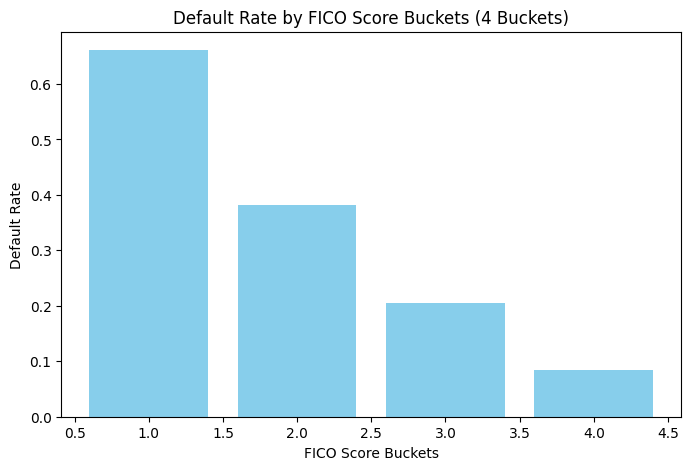

In [15]:
# Visualization of default rates by buckets
plt.figure(figsize=(8, 5))
plt.bar(bin_summary['bucket'], bin_summary['default_rate'], color='skyblue')
plt.xlabel('FICO Score Buckets')
plt.ylabel('Default Rate')
plt.title(f'Default Rate by FICO Score Buckets ({num_buckets} Buckets)')
plt.show()